## Same as LSTM -- 1, but uses lag of 3 days prior

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from datetime import datetime

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import tensorflow as tf

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [18]:
# load dataset
dataset = read_csv("C:/Users/3PX00LA_RS4/Documents/ATOS challenge/Damanda Diaria/Models/DataFinalLSTMCleaned.csv", header=0, index_col=0)
values = dataset.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag days
n_days = 3
n_features = 33

# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)

(2188, 136)


In [19]:
# split into train and test sets
values = reframed.values
n_train_days = 365 * 3
train = values[:n_train_days, :]
test = values[n_train_days:, :]

# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1095, 99) 1095 (1095,)
(1095, 3, 33) (1095,) (1093, 3, 33) (1093,)


Train on 1095 samples, validate on 1093 samples
Epoch 1/50
1095/1095 - 3s - loss: 0.2569 - val_loss: 0.2326
Epoch 2/50
1095/1095 - 0s - loss: 0.2351 - val_loss: 0.2263
Epoch 3/50
1095/1095 - 0s - loss: 0.2281 - val_loss: 0.2221
Epoch 4/50
1095/1095 - 0s - loss: 0.2247 - val_loss: 0.2181
Epoch 5/50
1095/1095 - 0s - loss: 0.2219 - val_loss: 0.2154
Epoch 6/50
1095/1095 - 0s - loss: 0.2209 - val_loss: 0.2136
Epoch 7/50
1095/1095 - 0s - loss: 0.2196 - val_loss: 0.2127
Epoch 8/50
1095/1095 - 0s - loss: 0.2199 - val_loss: 0.2160
Epoch 9/50
1095/1095 - 0s - loss: 0.2171 - val_loss: 0.2113
Epoch 10/50
1095/1095 - 0s - loss: 0.2120 - val_loss: 0.2089
Epoch 11/50
1095/1095 - 0s - loss: 0.2102 - val_loss: 0.2085
Epoch 12/50
1095/1095 - 0s - loss: 0.2098 - val_loss: 0.2072
Epoch 13/50
1095/1095 - 0s - loss: 0.2088 - val_loss: 0.2062
Epoch 14/50
1095/1095 - 0s - loss: 0.2077 - val_loss: 0.2053
Epoch 15/50
1095/1095 - 0s - loss: 0.2069 - val_loss: 0.2043
Epoch 16/50
1095/1095 - 0s - loss: 0.2063 - va

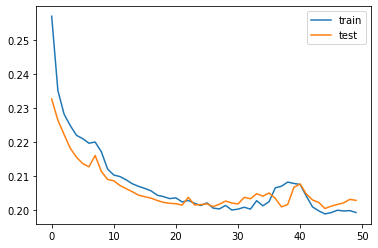

In [20]:
# design network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [21]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -33:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -33:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 36.703
